## Final Project Submission

Please fill out:
* Student name: Carl Cook
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


# Introduction

In this notebook, we're using the King County Housing Database to create a model for the price of homes using multiple linear regression. We'll be using the OSEMN workflow process to take us through step-by-step.

# Obtain

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
# get the data
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Scrub

## Check data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


* 'id' is just an identifier and should have no bearing on the model.
* 'date' and 'sqft_basement' are strings
* Everything else is numeric.
* We can probably remove 'sqft_above' and make 'sqft_basement' binary.
* 'waterfront' is binary


In [4]:
df_scrub = df.copy()
columns = df_scrub.columns
for col in columns:
    print(f'{col}: {df[col].nunique()} unique {type(df[col][0])}')

id: 21420 unique <class 'numpy.int64'>
date: 372 unique <class 'str'>
price: 3622 unique <class 'numpy.float64'>
bedrooms: 12 unique <class 'numpy.int64'>
bathrooms: 29 unique <class 'numpy.float64'>
sqft_living: 1034 unique <class 'numpy.int64'>
sqft_lot: 9776 unique <class 'numpy.int64'>
floors: 6 unique <class 'numpy.float64'>
waterfront: 2 unique <class 'numpy.float64'>
view: 5 unique <class 'numpy.float64'>
condition: 5 unique <class 'numpy.int64'>
grade: 11 unique <class 'numpy.int64'>
sqft_above: 942 unique <class 'numpy.int64'>
sqft_basement: 304 unique <class 'str'>
yr_built: 116 unique <class 'numpy.int64'>
yr_renovated: 70 unique <class 'numpy.float64'>
zipcode: 70 unique <class 'numpy.int64'>
lat: 5033 unique <class 'numpy.float64'>
long: 751 unique <class 'numpy.float64'>
sqft_living15: 777 unique <class 'numpy.int64'>
sqft_lot15: 8682 unique <class 'numpy.int64'>


## Dealing with null values

waterfront: 2376 null values


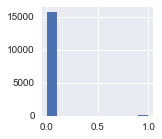

view: 63 null values


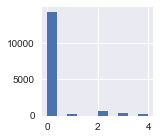

yr_renovated: 3842 null values


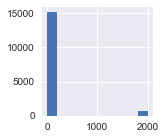

In [5]:
for col in columns:
    if df[col].isna().sum() > 0:
        print(f'{col}: {df[col].isna().sum()} null values')
        fig, ax = plt.subplots(figsize=(2,2))
        ax.hist(df.dropna()[col])
        plt.show()

Since these columns are all very heavy on zeroes, we'll just replace the null values with zero.

In [6]:
df_scrub = df_scrub.fillna(0)

Let's make a categorical column for basement

In [7]:
df_scrub['sqft_basement'] = df_scrub['sqft_living'] - df_scrub['sqft_above']
df_scrub['basement'] = [1 if x > 0 else 0 for x in df_scrub['sqft_basement']]
df_scrub = df_scrub.drop(columns='sqft_basement')

Let's do the same with renovation.

In [8]:
df_scrub['renovated'] = [1 if x > 0 else 0 for x in df_scrub['yr_renovated']]
df_scrub = df_scrub.drop(columns='yr_renovated')

## Categoricals

In [9]:
df_scrub.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,1965,98136,47.5208,-122.393,1360,5000,1,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0


### Date

In [10]:
for i in range(len(df_scrub)):
    date_temp = df_scrub.date[i].split('/')
    del date_temp[1]
    df_scrub.date[i] = '_'.join(date_temp)

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
df_scrub = pd.concat([df_scrub, pd.get_dummies(df_scrub['date'], prefix='date', drop_first=True)],
                    axis=1).drop(['date'], axis=1)

In [12]:
df_scrub.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,date_1_2015,date_2_2015,date_3_2015,date_4_2015,date_5_2014,date_5_2015,date_6_2014,date_7_2014,date_8_2014,date_9_2014
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,0,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,0,0,0


### Zipcode

In [13]:
# Thanks to Chris for this lovely dictionary!

subregion_dict = {'south_urban': [98001, 98002, 98003, 98023, 98030, 98031, 98032, 98042, 
                                 98055, 98056, 98058, 98092, 98148, 98166, 98168, 98178, 98188,
                                 98198], 
                 'east_urban' : [98004, 98005, 98006, 98007, 98008, 98009, 98027, 98029, 
                                 98033, 98034, 98039, 98040, 98052, 98053, 98059, 98074, 
                                98075, 98077],
                 'south_rural' : [98010, 98022, 98038],
                 'north' : [98011, 98028, 98072, 98155],
                 'east_rural' : [98014, 98019, 98024, 98045, 98065],
                 'vashon_island' : [98070], 
                 'seattle' : [98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115,
                             98116, 98117, 98118, 98119, 98122, 98125, 98126, 98136, 98144, 98199], 
                 'north_and_seattle' : [98133, 98177], 
                 'south_and_seattle' : [98146]}

In [14]:
regions = []
for i in range(len(df_scrub)):
    zip_val = df_scrub.zipcode[i]
    for key, val in subregion_dict.items():
        if zip_val in val:
            regions.append(key)
df_scrub['region'] = regions

In [15]:
df_scrub = pd.concat([df_scrub, pd.get_dummies(df_scrub['region'], prefix='region', drop_first=True)],
                     axis=1).drop(['zipcode', 'region'], axis=1)

In [16]:
df_scrub['waterfront'] = df_scrub['waterfront'].astype('int')
df_scrub['view'] = df_scrub['view'].astype('int')

In [17]:
df_scrub.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,date_8_2014,date_9_2014,region_east_urban,region_north,region_north_and_seattle,region_seattle,region_south_and_seattle,region_south_rural,region_south_urban,region_vashon_island
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,0,0,0,0,0,0,0,1,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,0,0,0,0,0,1,0,0,0,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,0,0,0,0,0,1,0,0,0,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,0,1,0,0,0,0,0,0,0


## Outliers

In [18]:
num_cols = ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
           'lat', 'long', 'sqft_living15', 'sqft_lot15']
df_ol = df_scrub[num_cols].copy()

In [19]:
columns = df_ol.columns

for col in columns:
    z = np.abs(stats.zscore(df_ol[col]))
    num_ol = (z > 3).sum()
    print(f'{col}: {num_ol} outliers')

id: 0 outliers
price: 406 outliers
bedrooms: 62 outliers
bathrooms: 187 outliers
sqft_living: 248 outliers
sqft_lot: 346 outliers
floors: 7 outliers
view: 825 outliers
condition: 29 outliers
grade: 130 outliers
sqft_above: 253 outliers
yr_built: 0 outliers
lat: 0 outliers
long: 232 outliers
sqft_living15: 236 outliers
sqft_lot15: 363 outliers


C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


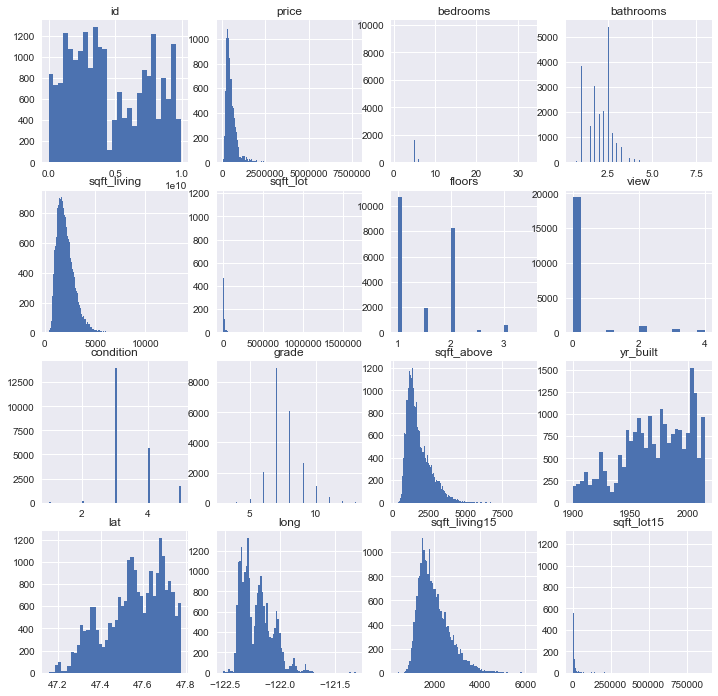

In [20]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i, col in enumerate(df_ol.columns):
    ax[i//4,i%4].hist(df[col], bins='auto')
    ax[i//4,i%4].set_title(col)

In [28]:
z = np.abs(stats.zscore(df_ol))
df_olr = df_ol[(z <= 4).all(axis=1)]

In [29]:
removed = df_scrub.shape[0] - df_olr.shape[0]
print(f'df_scrub: {df_scrub.shape}')
print(f'df_olr: {df_olr.shape}')
print(f'{removed} rows removed.')
print(f'{round((removed/df_scrub.shape[0])*100 , 2)}% data loss.')

df_scrub: (21597, 39)
df_olr: (20651, 16)
946 rows removed.
4.38% data loss.


## Normalize

In [54]:
df_norm = (df_olr - df_olr.mean()) / df_olr.std()

In [49]:
df_norm['id'] = df_olr['id']

In [50]:
df_norm.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
0,7129300520,-1.051351,-0.401791,-1.488025,-1.028292,-0.357801,-0.901942,-0.277529,-0.631283,-0.541793,-0.741031,-0.537756,-0.356900,-0.291389,-0.945979,-0.372710
1,6414100192,0.114634,-0.401791,0.235797,0.683444,-0.244809,0.951761,-0.277529,-0.631283,-0.541793,0.575429,-0.673824,1.158636,-0.746817,-0.401594,-0.192067
2,5631500400,-1.205906,-1.543425,-1.488025,-1.533192,-0.049061,-0.901942,-0.277529,-0.631283,-1.452765,-1.286231,-1.286130,1.280717,-0.115094,1.200452,-0.153650
3,2487200875,0.358086,0.739842,1.270091,-0.067750,-0.403935,-0.901942,-0.277529,2.450660,-0.541793,-0.913899,-0.197586,-0.287553,-1.290392,-0.914871,-0.431743
4,1954400510,0.011352,-0.401791,-0.108967,-0.412560,-0.185332,-0.901942,-0.277529,-0.631283,0.369180,-0.076152,0.550789,0.405925,1.265881,-0.230502,-0.204419


In [51]:
df_norm.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
count,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04,2.065100e+04
mean,4.620646e+09,-7.156694e-17,-1.720359e-16,1.981854e-16,-6.055664e-17,-5.505149e-17,1.101030e-17,2.614946e-17,-3.853604e-17,-5.505149e-17,-1.156081e-16,1.651545e-15,-5.642830e-14,-3.890965e-12,-1.183607e-16,1.101030e-17
std,2.874331e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000102e+06,-1.582149e+00,-2.685058e+00,-2.177554e+00,-2.025778e+00,-7.219017e-01,-9.019421e-01,-2.775286e-01,-3.713225e+00,-4.185683e+00,-1.818134e+00,-2.408692e+00,-2.775402e+00,-2.164520e+00,-2.314717e+00,-8.267232e-01
25%,2.149800e+09,-6.968709e-01,-4.017913e-01,-7.984960e-01,-7.450550e-01,-4.039346e-01,-9.019421e-01,-2.775286e-01,-6.312825e-01,-5.417929e-01,-7.410307e-01,-6.738240e-01,-6.400703e-01,-8.202726e-01,-7.437788e-01,-4.285192e-01
50%,3.975400e+09,-2.357885e-01,-4.017913e-01,2.357975e-01,-1.662668e-01,-2.270655e-01,-9.019421e-01,-2.775286e-01,-6.312825e-01,-5.417929e-01,-2.623181e-01,1.085675e-01,8.157943e-02,-1.297852e-01,-1.993943e-01,-2.046911e-01
75%,7.338401e+09,4.352708e-01,7.398421e-01,5.805620e-01,5.849265e-01,-3.561100e-02,9.517607e-01,-2.775286e-01,9.096886e-01,3.691796e-01,5.488336e-01,8.569420e-01,8.545176e-01,6.415041e-01,5.627440e-01,3.288642e-03
max,9.900000e+09,5.507454e+00,4.164742e+00,4.028207e+00,4.587185e+00,1.185036e+01,3.732315e+00,4.789884e+00,2.450660e+00,4.013070e+00,4.405129e+00,1.503265e+00,1.567499e+00,3.976412e+00,4.280113e+00,1.011229e+01


# Explore

## price

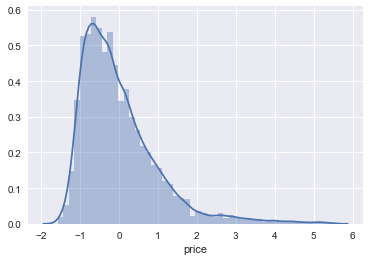

In [53]:
sns.distplot(df_norm.price)

## bedrooms

## bathrooms

## sqft_living

## sqft_lot

## floors

## view

## condition

## grade

# Model

# iNterpret

In [3]:
df = pd.read_pickle('non_norm_data.pkl')

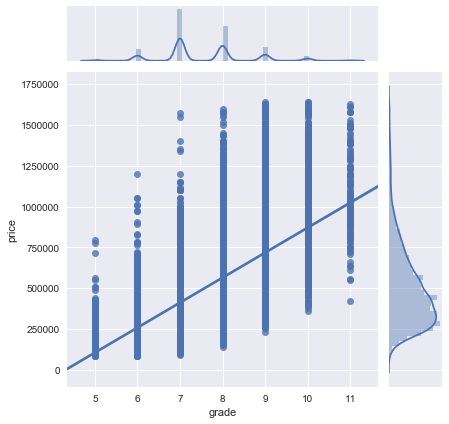

In [6]:
sns.jointplot('grade', 'price', df, kind='reg')

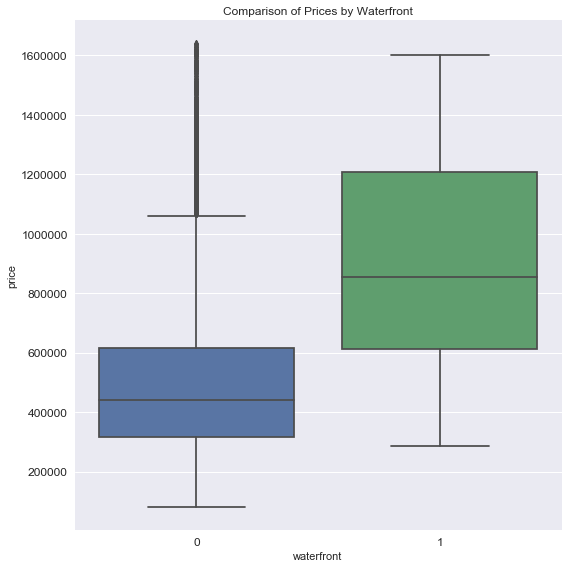

In [20]:
plt.subplots(figsize=(8,8))
sns.boxplot(df.waterfront, df.price)
plt.title('Comparison of Prices by Waterfront')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('waterfront_price.png')

In [17]:
def joint(col):
    sns.jointplot(col, 'price', df, kind='reg')
    plt.tight_layout()
    plt.savefig(f'{col}_price')

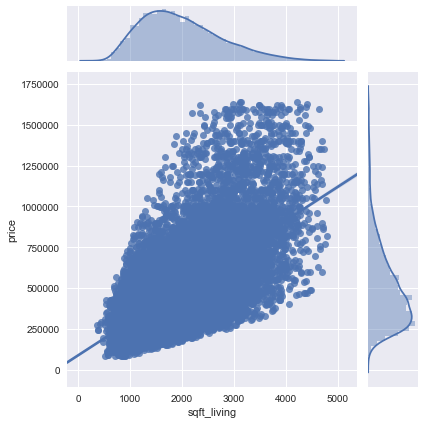

In [18]:
joint('sqft_living')

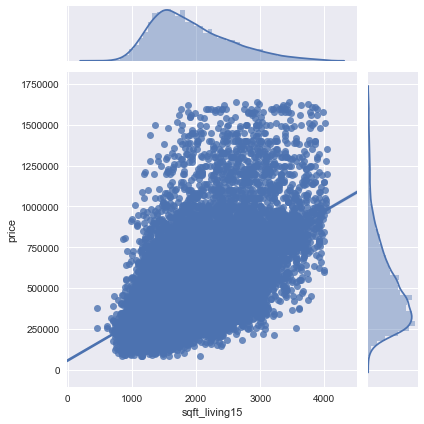

In [19]:
joint('sqft_living15')

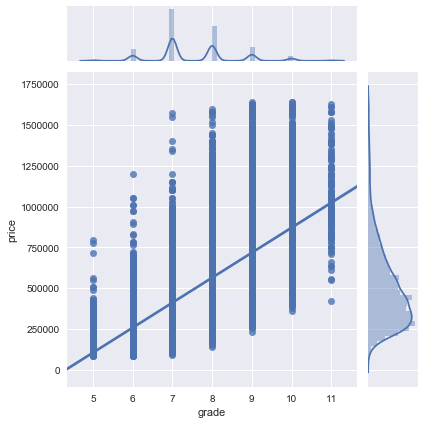

In [21]:
joint('grade')